# Capstone Project - The Battle of the Neighbourhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find an optimal location for a Coffee Shop. Specifically, this report will be targeted to stakeholders interested in opening an **Coffee Shop** in **Toronto**, **Canada**.


Considering that the success of the Coffee Shop operation depends on several factors, in this analysis we will address two. One is the number of Coffee Shop that already exist in the neighbourhood, since these will be the competition of our Coffee Shop. The second is the number of consumers who attend the competing Coffee Shops since these are the potential consumers for ours.

Finally, a segmentation and classification of neighbourhoods will be carried out based on the criteria indicated to determine the one that meets the ideal condition, that is, a neighbourhood with a low density of Coffee Shop and a high number of consumers per Coffee Shop.

## Data <a name="data"></a>

To develop this project I will use:

* The location (latitude and longitude) of each Toronto neighbourhood, obtained from the Wikipedia website.

* The Coffee Shop located within a radius of 225 meters from the center of every neighbourhood, obtain with the foursquare data location and **search** endpoint.

* The distance at which each of the Coffee Shop is located from the center of the neighbourhood, obtain with the API of foursquare data location and **search** endpoint.

* The number of likes that each of these Coffee Shop had, obtain with the API of foursquare data location and search **likes**. 

### Neighborhood Candidates

In first place it's neccesary obtain the latitude & longitude coordinates for centroids of our candidate neighborhoods. To achieve this, scrape Wikipedia page of the articule named "List of postal codes of Canada: M" to extract a list of postal code with a respective borough and neighbourhoodthe. 

In [121]:
# To import the library and module necessary to obtain the table of wikipedia page

import pandas as pd
from pandas.io.html import read_html

In [122]:
# To get the table of postal codes

page = 'https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&direction=prev&oldid=946126446'

wikitables = read_html(page,  attrs={"class":"wikitable"})

print ("Extracted {num} wikitables".format(num=len(wikitables)))

PC_Canada = wikitables[0]

PC_Canada.head()

Extracted 1 wikitables


,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


Now, it's necessary filter the dataframe to supr the rows with the value "Not assigned" and then group the Neighbourhood for Postal code. 

In [123]:
# To filter the Borough that are 'Not assigned'
PC_Canada = PC_Canada[PC_Canada['Borough'] != 'Not assigned']


# To check if exist neighbourhood that are 'Not assigned'
PC_Canada[PC_Canada['Neighbourhood'] == 'Not assigned']


# Finally, to group neighbourhood by postcode and borough
PC_Canada = PC_Canada.groupby(['Postcode','Borough'])['Neighbourhood'].apply(', '.join).reset_index()

print("The dataframe has", PC_Canada.shape[0], "rows and", PC_Canada.shape[1], "columns")
PC_Canada.head()

The dataframe has 103 rows and 3 columns


,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


Then, is necessary obtain the latitude and longitude of each neighbourhoods. To do that use the dataframe in the website "Geospatial Data".

In [124]:
url_geo = "http://cocl.us/Geospatial_data"
lat_lng_coord = pd.read_csv(url_geo)

print("The dataframe has", lat_lng_coord.shape[0], "rows and", lat_lng_coord.shape[1], "columns")
lat_lng_coord.head()

The dataframe has 103 rows and 3 columns


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Then, is necessary merge both data frames

In [125]:
PC_Canada_LL = pd.merge(PC_Canada, lat_lng_coord, how='left', left_on='Postcode', right_on='Postal Code')
PC_Canada_LL = PC_Canada_LL[['Postal Code','Borough','Neighbourhood','Latitude','Longitude']]

print("The dataframe has", PC_Canada_LL.shape[0], "rows and", PC_Canada_LL.shape[1], "columns")
PC_Canada_LL.head()

The dataframe has 103 rows and 5 columns


,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


### Foursquare


Use the Foursquare API to obtain data of venue around the center of each neighborhood. How in the introduction says, the venues of interes are of the **Coffee Shop** category. So include in the search API of foursquare in the parameter "search_query" the category **Coffee Shop**. Also include **225** in the parameter "radius", that means that the info obtain it´s of the venues lacated in a radius of **225** [mts] around the centre of the neighbourhood.

Other data relevant for this study is the 'id' of each venue, because below is used to obtain the number of **likes** associated to this.

In [126]:
# To import the library and module necessary to execute the Foursquare API.

import numpy as np
import json
import requests
from pandas.io.json import json_normalize

In [127]:
# The code was removed by Watson Studio for sharing.

In [128]:
# To create a function to obtain the venues near to all the neighborhoods in Toronto using foursquare API

LIMIT = 200
radius = 225
search_query = 'Coffee Shop' 

def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            search_query)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['id'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'], 
            v['venue']['location']['distance'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'id', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue distance',
                  'Venue Category']
    return(nearby_venues)

In [129]:
# To apply the funtion to each Toronto neighbourhoods

Toronto_venues = getNearbyVenues(names=PC_Canada_LL['Neighbourhood'],
                                   latitudes=PC_Canada_LL['Latitude'],
                                   longitudes=PC_Canada_LL['Longitude']
                                  )

In [130]:
print("Exist", Toronto_venues.shape[0], "venues in the near of the neighbourhoods")

Exist 271 venues in the near of the neighbourhoods


In [131]:
# To create a function to obtain the likes of each venue using foursquare API

venues_list_like = []

for i in Toronto_venues['id']:
            
    # create the API request URL
    url_3 = 'https://api.foursquare.com/v2/venues/{}/likes'.format(i)

    params = dict(
        client_id = CLIENT_ID,
        client_secret = CLIENT_SECRET,
        v= VERSION,
    )
            
    # make the GET request
    results_3 = requests.get(url=url_3, params=params).json()['response']['likes']['count']
    
    
    venues_list_like.append([(
        i,
        results_3)])
    
    
    # return only relevant information for each nearby venue
    likes_of_venues = pd.DataFrame([item for venue_list_like in venues_list_like for item in venue_list_like])
    
    likes_of_venues.columns = ['V_id', 
                  'likes'] 
    
    
print("Extracted the number of likes of", likes_of_venues.shape[0], "venues")

Extracted the number of likes of 271 venues


Then, is necessary merge bowth data frames

In [132]:
Info_Venue = Toronto_venues.merge(likes_of_venues, how='left', left_on='id', right_on='V_id', copy = False)
Info_Venue = Info_Venue.drop_duplicates()
print("The dataframe has", Info_Venue.shape[0], "rows and", Info_Venue.shape[1], "columns")

The dataframe has 271 rows and 11 columns


## Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting neighbourhoods of Toronto have low **Coffee Shop** density and a high number of likes.  
In first step we have collected the required **data: location and type (category) and number of likes of every Coffee Shop in the near of each neighbourhood of Toronto, Canada.**

Second step is see in a map if exist overlapping of the area (circles of 225 [mts] of radio) and venues of the neighbourhoods. then, is selected the neighbourhoods that not exist overlaping.  

In third, and final step, focus on classification the neighbourhoods according the density of coffe shop (Number and distance of venues) and the sumatorie of number of likes. To do that used the **k-means clustering.**

## Analysis <a name="analysis"></a>

Now, to graph the neighbourhoods and the venues that are in the result data, is necessary some of data procesing. 

First, obtain the neighbourhoods and the respective location coordinates that resulted in the previous data.

In [133]:
Neighbourhood_location = Info_Venue.groupby(['Neighbourhood'])['Neighbourhood Latitude','Neighbourhood Longitude'].mean().reset_index()
Neighbourhood_location.shape

(42, 3)

In [134]:
#import the librarys necessary to plot the map.

import matplotlib.cm as cm
import matplotlib.colors as colors
import folium

In [135]:
latitude = '43.704324'
longitude = '-79.388790'

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lon, poi in zip(Neighbourhood_location['Neighbourhood Latitude'], Neighbourhood_location['Neighbourhood Longitude'], Neighbourhood_location['Neighbourhood']):
    label = folium.Popup(str(poi), parse_html=True)
    #folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin) 
    folium.Circle([lat, lon],
                  radius=225,
                  color='blue',
                  popup=label, 
                  fill=False).add_to(map_clusters)
    
map_clusters

In [136]:
latitude = '43.647177'
longitude = '-79.381576'

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=15)

for lat, lon, poi in zip(Neighbourhood_location['Neighbourhood Latitude'], Neighbourhood_location['Neighbourhood Longitude'], Neighbourhood_location['Neighbourhood']):
    label = folium.Popup(str(poi), parse_html=True)
    #folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin) 
    folium.Circle([lat, lon],
                  radius=225,
                  color='blue',
                  popup=label, 
                  fill=False).add_to(map_clusters)
    
map_clusters

So, how the image present, exist overlaping in somes neighbourhoods, to solve this just filter.

In [137]:
N_location_filtered = Neighbourhood_location.loc[(Neighbourhood_location['Neighbourhood'] != 'First Canadian Place, Underground city')]
N_location_filtered = N_location_filtered.loc[(N_location_filtered['Neighbourhood'] != 'Berczy Park')]
N_location_filtered = N_location_filtered.loc[(N_location_filtered['Neighbourhood'] != 'Commerce Court, Victoria Hotel')]
N_location_filtered.shape

(40, 3)

In [138]:
I_Venue_filtered = Info_Venue[Info_Venue['Neighbourhood'].isin(N_location_filtered['Neighbourhood'])]
I_Venue_filtered.shape

(198, 11)

In [139]:
latitude = '43.647177'
longitude = '-79.381576'

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=15)

for lat, lon, poi in zip(N_location_filtered['Neighbourhood Latitude'], N_location_filtered['Neighbourhood Longitude'], N_location_filtered['Neighbourhood']):
    label = folium.Popup(str(poi), parse_html=True)
    #folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin) 
    folium.Circle([lat, lon],
                  radius=225,
                  color='blue',
                  popup=label, 
                  fill=False).add_to(map_clusters)
    
for lat, lon, poi in zip(I_Venue_filtered['Venue Latitude'], I_Venue_filtered['Venue Longitude'], I_Venue_filtered['Neighbourhood']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color= 'blue',
        fill=False).add_to(map_clusters)
    
map_clusters

### Cluster and classification

Now that neighbourhood info it's the correct, is necessary do some transformation previously to pass at cluster and classification process.

In [140]:
#To generate the number of venues per neighbourhood

Venues_x_N = I_Venue_filtered.groupby(['Neighbourhood'])['Venue'].count().reset_index()
Venues_x_N.head()

,Neighbourhood,Venue
0,"Adelaide, King, Richmond",17
1,"Alderwood, Long Branch",1
2,"Bathurst Manor, Downsview North, Wilson Heights",2
3,"Bedford Park, Lawrence Manor East",2
4,"Birch Cliff, Cliffside West",1


In [141]:
#To generate the distance acumulated per neighbourhood

Distance_x_N = I_Venue_filtered.groupby(['Neighbourhood'])['Venue distance'].sum().reset_index()
Distance_x_N.head()

,Neighbourhood,Venue distance
0,"Adelaide, King, Richmond",2609
1,"Alderwood, Long Branch",126
2,"Bathurst Manor, Downsview North, Wilson Heights",302
3,"Bedford Park, Lawrence Manor East",101
4,"Birch Cliff, Cliffside West",113


In [142]:
#To generate the likes acumulated per neighbourhood

Likes_x_N = I_Venue_filtered.groupby(['Neighbourhood'])['likes'].sum().reset_index()
Likes_x_N.head()

,Neighbourhood,likes
0,"Adelaide, King, Richmond",258
1,"Alderwood, Long Branch",2
2,"Bathurst Manor, Downsview North, Wilson Heights",62
3,"Bedford Park, Lawrence Manor East",21
4,"Birch Cliff, Cliffside West",10


In [143]:
#To merge the data that will be used to make the kmean model.

I_Venue_Km = Venues_x_N.merge(Distance_x_N, how='left', left_on='Neighbourhood', right_on='Neighbourhood', copy = False)
I_Venue_Km = I_Venue_Km.merge(Likes_x_N, how='left', left_on='Neighbourhood', right_on='Neighbourhood', copy = False)
I_Venue_Km.head()

,Neighbourhood,Venue,Venue distance,likes
0,"Adelaide, King, Richmond",17,2609,258
1,"Alderwood, Long Branch",1,126,2
2,"Bathurst Manor, Downsview North, Wilson Heights",2,302,62
3,"Bedford Park, Lawrence Manor East",2,101,21
4,"Birch Cliff, Cliffside West",1,113,10


Now, extract only the variables to apply a standar transformation. 

In [144]:
I_Venue_Var = I_Venue_Km[['Venue', 'Venue distance','likes']]
I_Venue_Var.head()

,Venue,Venue distance,likes
0,17,2609,258
1,1,126,2
2,2,302,62
3,2,101,21
4,1,113,10


In [145]:
from sklearn.preprocessing import StandardScaler

I_Venue_Var_S = StandardScaler().fit_transform(I_Venue_Var)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [146]:
I_Venue_Var_Std = pd.DataFrame({'Venue': I_Venue_Var_S[:, 0], 'Venue distance': I_Venue_Var_S[:, 1], 'likes': I_Venue_Var_S[:, 2]})

I_Venue_Var_Std.head()

,Venue,Venue distance,likes
0,1.821841,1.976908,1.334918
1,-0.597201,-0.645836,-0.563632
2,-0.446011,-0.459931,-0.118659
3,-0.446011,-0.672243,-0.422724
4,-0.597201,-0.659568,-0.504302


In [147]:
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

Toronto_clustering = I_Venue_Var_Std

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 1, 1, 1, 1, 1, 1, 3, 1, 1, 0, 4, 1, 3, 3, 1, 1, 1, 2, 3, 1, 1,
       3, 1, 3, 1, 1, 1, 1, 1, 1, 0, 3, 1, 3, 1, 1, 1, 1, 1], dtype=int32)

Now, to make sure that the cluster and classification process is correct, make a grafp of this.

In [148]:
#To insert the cluster in the venues data frames

I_Venue_Var_Std.insert(0, 'Cluster Labels', kmeans.labels_)
I_Venue_Var.insert(0, 'Cluster Labels', kmeans.labels_)

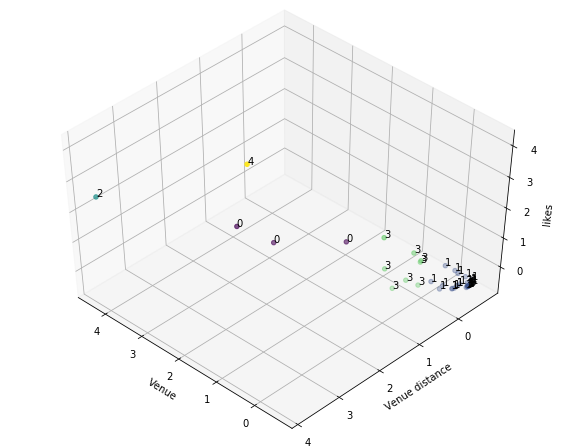

In [149]:
# To graph the clusters

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

cs = kmeans.labels_
xs = I_Venue_Var_S[:, 0]
ys = I_Venue_Var_S[:, 1]
zs = I_Venue_Var_S[:, 2]

for c, x, y, z in zip(cs, xs, ys, zs):
    label = c
    ax.text(x, y, z, label)

ax.set_xlabel('Venue')
ax.set_ylabel('Venue distance')
ax.set_zlabel('likes')

ax.scatter(I_Venue_Var_S[:, 0], I_Venue_Var_S[:, 1], I_Venue_Var_S[:, 2], c= kmeans.labels_.astype(np.float))

Then, to understood in a better way the characteristcs of the cluster, group the data frame. 

In [150]:
I_Venue_Var.groupby(['Cluster Labels'])['Venue', 'Venue distance', 'likes'].mean().reset_index()

,Cluster Labels,Venue,Venue distance,likes
0,0,16.000000,2465.666667,281.333333
1,1,1.740741,256.111111,13.518519
2,2,34.000000,4345.000000,416.000000
3,3,6.375000,974.500000,107.250000
4,4,18.000000,3044.000000,637.000000


How the graph shows,the clusterization and segmentation it's correct. Now its good see the clusters in the map.

In [151]:
#To insert the cluster in the Neighbourhood info.

N_location_filtered.insert(0, 'Cluster Labels', kmeans.labels_ )

N_location_filtered.head()

,Cluster Labels,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude
0,0,"Adelaide, King, Richmond",43.650571,-79.384568
1,1,"Alderwood, Long Branch",43.602414,-79.543484
2,1,"Bathurst Manor, Downsview North, Wilson Heights",43.754328,-79.442259
3,1,"Bedford Park, Lawrence Manor East",43.733283,-79.419750
4,1,"Birch Cliff, Cliffside West",43.692657,-79.264848


In [153]:
latitude = '43.704324'
longitude = '-79.388790'

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi in zip(I_Venue_filtered['Venue Latitude'], I_Venue_filtered['Venue Longitude'], I_Venue_filtered['Neighbourhood']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color= 'blue',
        fill=False).add_to(map_clusters)

for lat, lon, poi, cluster in zip(N_location_filtered['Neighbourhood Latitude'], N_location_filtered['Neighbourhood Longitude'], N_location_filtered['Neighbourhood'], N_location_filtered['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    #folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin) 
    folium.Circle(
        [lat, lon],
        radius=225,
        color=rainbow[cluster-1],
        fill=True,
        popup=label,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

In [154]:
N_cluster_filtered = N_location_filtered.loc[(N_location_filtered['Cluster Labels'] != 1)]
N_cluster_filtered = N_cluster_filtered.loc[(N_cluster_filtered['Cluster Labels'] != 3)]
N_cluster_filtered = N_cluster_filtered.loc[(N_cluster_filtered['Cluster Labels'] != 2)]
N_cluster_filtered

,Cluster Labels,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude
0,0,"Adelaide, King, Richmond",43.650571,-79.384568
10,0,Central Bay Street,43.657952,-79.387383
11,4,"Chinatown, Grange Park, Kensington Market",43.653206,-79.400049
33,0,"Ryerson, Garden District",43.657162,-79.378937


In [155]:
I_Venue_filtered_c = I_Venue_filtered[I_Venue_filtered['Neighbourhood'].isin(N_cluster_filtered['Neighbourhood'])]

In [156]:
latitude = '43.647177'
longitude = '-79.381576'

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=14)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi in zip(I_Venue_filtered_c['Venue Latitude'], I_Venue_filtered_c['Venue Longitude'], I_Venue_filtered_c['Neighbourhood']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color= 'blue',
        fill=False).add_to(map_clusters)

for lat, lon, poi, cluster in zip(N_cluster_filtered['Neighbourhood Latitude'], N_cluster_filtered['Neighbourhood Longitude'], N_cluster_filtered['Neighbourhood'], N_cluster_filtered['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    #folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin) 
    folium.Circle(
        [lat, lon],
        radius=225,
        color=rainbow[cluster-1],
        fill=True,
        popup=label,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

## Results and Discussion <a name="results"></a>

Our analysis shows that exist a great number of neighbourhoods available to opening a coffee shop. however "tambien" shows that exist a great number of coffee shop that already exist.After that apply the cluster and segmentation, is easy discard a big number of neighbourhood because the number of likes of the coffee shops for this it´s low, mostly this neighbourhoods are placed out of the center of Toronto and corresponding to the cluster 1. Then the others candidates have a significant number of likes, so the other aspect to see is the density of caffe shops. In this way the neighbourdhood 'Design Exchange, Toronto Dominion Centre Cluster' (the only one cluster 2) have a very high level of density of caffe shop but not high level of likes, so its eliminated of posible candidates. Finally the neighbourhoods selected are cluster 0 and cluster 4, becouse has the better condition of density of caffe shops and likes,  with emphasis in the neighbourhood 'Chinatown, Grange Park, Kensington Market' (the only one cluster 4) becouse present the most high level of likes, almost double of the mean of cluster 0, but same level of density of venues. 

## Conclusion <a name="conclusion"></a>

<!-- ## Conclusion <a name="conclusion"></a> -->

Purpose of this project was to identify Toronto neighbourhoods close to center with low number of coffe shops and high levels of likes. By calculating coffe shops density distribution from Foursquare data we have first identified general neighbourhoods that some basic requirements regarding existing nearby coffe shops. Clustering of those neighbourhoods was then performed in order determine the better location. 

Final decission on optimal restaurant location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location, levels of noise,  proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood, etc.